# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import namedtuple
import random

opt = [
 ("dataroot", "/home/adalbert/data/urban-atlas/extracted-data/"), 
 ("workers", 2),
 ("batchSize",64), 
 ("imageSize",64),
 ("nz",100),
 ("ngf",64), # nr filters for generator
 ("ndf",64), # nr filters for discriminator
 ("niter",25),
 ("lr",0.0002),
 ("beta1",0.5), 
 ("cuda",True),
 ("ngpu",1),
 ("netG",""),
 ("netD",""),
 ("outf","/home/adalbert/nbserver/pytorch-workspace/dcgan/urban-environments/"),
 ("manualSeed",  random.randint(1, 10000)) 
]
opt = namedtuple("opt", dict(opt).keys())(**dict(opt))

opt

opt(niter=25, ngf=64, imageSize=64, manualSeed=878, netG='', workers=2, netD='', ndf=64, nz=100, lr=0.0002, cuda=True, beta1=0.5, dataroot='/home/adalbert/data/urban-atlas/extracted-data/', ngpu=1, batchSize=64, outf='/home/adalbert/nbserver/pytorch-workspace/dcgan/urban-environments/')

# Set up data sources

In [3]:
experiment_files_train = glob.glob("/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/*-train.csv")
experiment_files_test  = glob.glob("/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/*-test.csv")

experiment_files_train = {os.path.basename(f).split("-")[0]:f \
                          for f in experiment_files_train}
experiment_files_test = {os.path.basename(f).split("-")[0]:f \
                          for f in experiment_files_test}

In [4]:
train_file = experiment_files_train['berlin+bucuresti+dublin+tallinn+barcelona']
train_df = pd.read_csv(train_file)
print "training file:"
print train_file

test_file = experiment_files_test['berlin+bucuresti+dublin+tallinn+barcelona']
test_df = pd.read_csv(test_file)
print
print "test file:"
print test_file

outfolder = opt.outf + os.path.basename(train_file).replace("-train.csv","")
print 
print "outfolder:"
print outfolder

training file:
/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/berlin+bucuresti+dublin+tallinn+barcelona-train.csv

test file:
/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/berlin+bucuresti+dublin+tallinn+barcelona-test.csv

outfolder:
/home/adalbert/nbserver/pytorch-workspace/dcgan/urban-environments/berlin+bucuresti+dublin+tallinn+barcelona


In [5]:
len(train_df)

111841

# Train - spawn external process

In [6]:
script_path = "../models/dcgan-mod.py"
cmd = "python {0} --cuda --dataset=csvfile --dataroot={1} --niter={2} --ngpu={3} --outf={4} --imageSize={5}".format(script_path, train_file, opt.niter, opt.ngpu, outfolder, opt.imageSize)
cmd

'python ../models/dcgan-mod.py --cuda --dataset=csvfile --dataroot=/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/berlin+bucuresti+dublin+tallinn+barcelona-train.csv --niter=25 --ngpu=1 --outf=/home/adalbert/nbserver/pytorch-workspace/dcgan/urban-environments/berlin+bucuresti+dublin+tallinn+barcelona --imageSize=64'

In [ ]:
# os.system(cmd)

# Plot fake and real samples

In [7]:
files_fake = glob.glob(outfolder + "/fake*.png")
files_fake.sort()

files_real = glob.glob(outfolder + "/real*.png")

files_cptD = glob.glob(outfolder + "/netD*.pth")
files_cptD.sort()
files_cptG = glob.glob(outfolder + "/netG*.pth")
files_cptG.sort()

print len(files_fake)

30


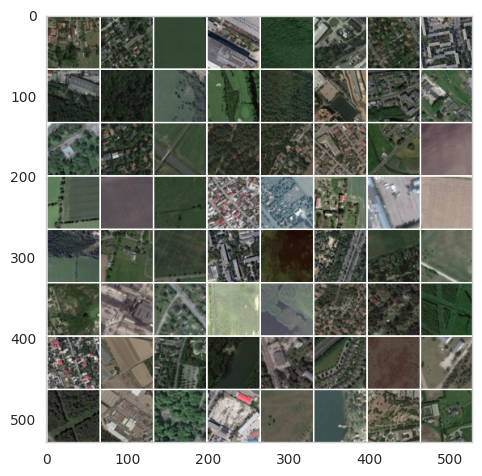

In [8]:
plt.imshow(imread(files_real[0]))

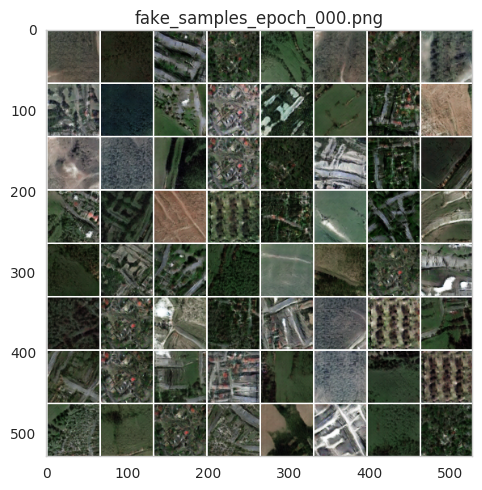

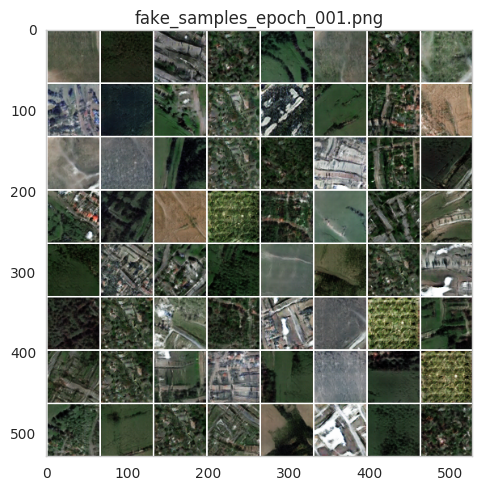

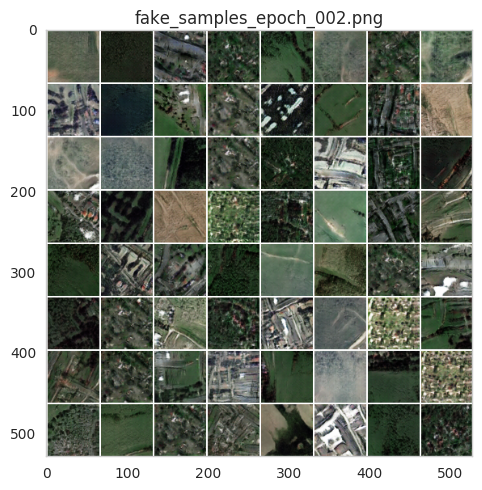

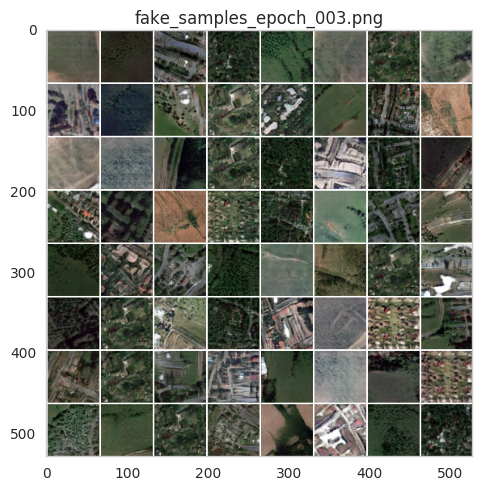

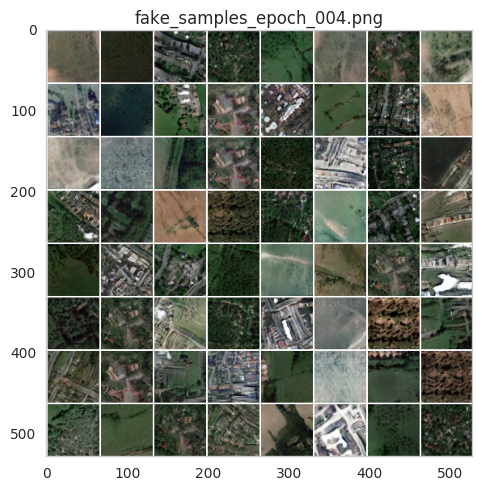

In [9]:
for f in files_fake[:5]:
    img = imread(f)
    plt.imshow(img)
    plt.title(os.path.basename(f))
    plt.show()

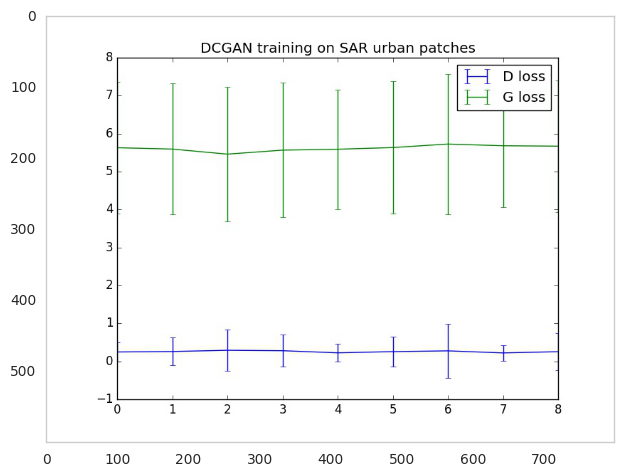

In [10]:
img = imread("/home/adalbert/nbserver/pytorch-workspace/dcgan/urban-environments/berlin+bucuresti+dublin+tallinn+barcelona/training_progress.jpg")

plt.imshow(img)

# Clustering with GAN generator features

In [11]:
files_cptD = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptD}

files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}

In [15]:
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
nc = 3

In [16]:
import torch.nn as nn
import torch.nn.parallel
import torchvision.transforms as transforms

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        output = nn.parallel.data_parallel(self.main, input, gpu_ids)
        return output.view(-1, 1)
    
netD = _netD(ngpu)
netD.apply(weights_init)

class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        return nn.parallel.data_parallel(self.main, input, gpu_ids)

netG = _netG(ngpu)
netG.apply(weights_init)


_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)

In [17]:
netD.load_state_dict(torch.load(files_cptD[max(files_cptD.keys())]))

feature_extractor = nn.Sequential(*list(list(netD.children())[0].children())[:-2])

In [18]:
sys.path.append("../pytorch-utils")
from loader_dataframe import ImageDataFrame, grayscale_loader

dataset = ImageDataFrame(df=test_df,
                         transform=transforms.Compose([
                               transforms.Scale(opt.imageSize),
                               transforms.CenterCrop(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                     shuffle=False, num_workers=int(opt.workers))


In [19]:
from torch.autograd import Variable

input = torch.FloatTensor(opt.batchSize, nc, opt.imageSize, opt.imageSize)

if opt.cuda:
    netD.cuda()
    input = input.cuda()

input = Variable(input)

In [20]:
labels = []
features = []
for i, data in enumerate(dataloader):
    netD.zero_grad()
    real_cpu, lab_batch = data
    batch_size = real_cpu.size(0)
    input.data.resize_(real_cpu.size()).copy_(real_cpu)
    feat_batch = feature_extractor(input)
    feat_batch = feat_batch.data.cpu().numpy().reshape((batch_size,-1))
    
    features.append(feat_batch)
    labels.append(lab_batch.numpy())

features = np.vstack(features)
labels = np.hstack(labels)

In [21]:
features.shape, labels.shape

((27961, 8192), (27961,))

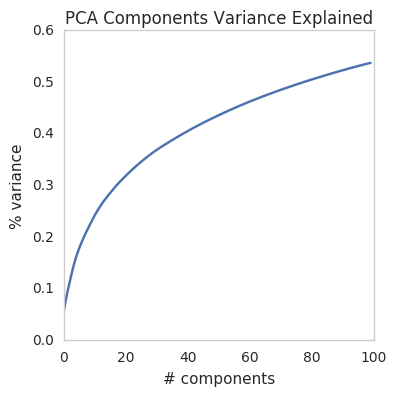

In [22]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=100)

feat_reduced = pca.fit_transform(features)[:,:100]

plt.figure(figsize=(4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Components Variance Explained")
plt.xlabel("# components")
plt.ylabel("% variance")

In [ ]:
# # https://github.com/DmitryUlyanov/Multicore-TSNE

# from MulticoreTSNE import MulticoreTSNE as TSNE

# tsne = TSNE(n_components=20, perplexity=30)
# feats_tsne = tsne.fit_transform(features.astype(np.float64))

In [23]:
from sklearn.cluster import KMeans#, MiniBatchKMeans

loss_vec = []
k_vec = np.linspace(5, 150, 40)
for k in k_vec:
    print int(k),
    kmeans = KMeans(n_jobs=32, n_clusters=int(k), random_state=0).fit(feat_reduced)
    loss = -kmeans.score(feat_reduced)
    loss_vec.append(loss)

5 8 12 16 19 23 27 31 34 38 42 45 49 53 57 60 64 68 71 75 79 83 86 90 94 97 101 105 109 112 116 120 123 127 131 135 138 142 146 150


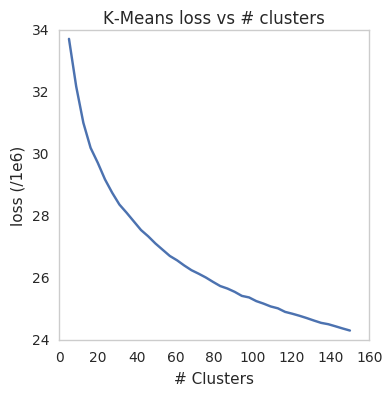

In [24]:
plt.figure(figsize=(4,4))
plt.plot(k_vec, np.array(loss_vec)/1e6)
plt.title("K-Means loss vs # clusters")
plt.xlabel("# Clusters")
plt.ylabel("loss (/1e6)")

In [25]:
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=32).fit(feat_reduced)

C = kmeans.predict(feat_reduced)

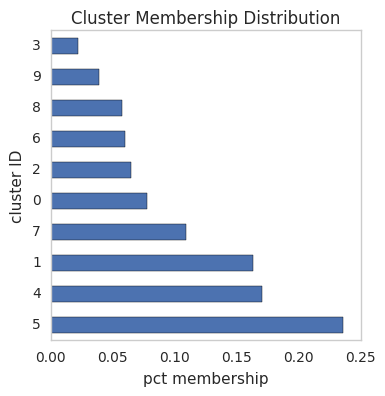

In [26]:
(pd.Series(C).value_counts() / float(len(C))).plot(kind="barh", figsize=(4,4))
plt.title("Cluster Membership Distribution")
plt.xlabel("pct membership")
plt.ylabel("cluster ID")

In [27]:
def plot_examples(image_paths, labels, classes=None, \
                  nExamples=10, nc=3, thumbSize = (64,64), title="example"):
    # build example canvass 
    from skimage.transform import resize
    from skimage.io import imread
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.zeros((thumbSize[0]*nClusters, nExamples*thumbSize[1], nc))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = imread(image_paths[idx[j]])
            img = resize(img, thumbSize)
            canvas[i*thumbSize[0]:(i+1)*thumbSize[0], j*thumbSize[1]:(j+1)*thumbSize[1]] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print canvas.shape
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

(640, 640, 3)


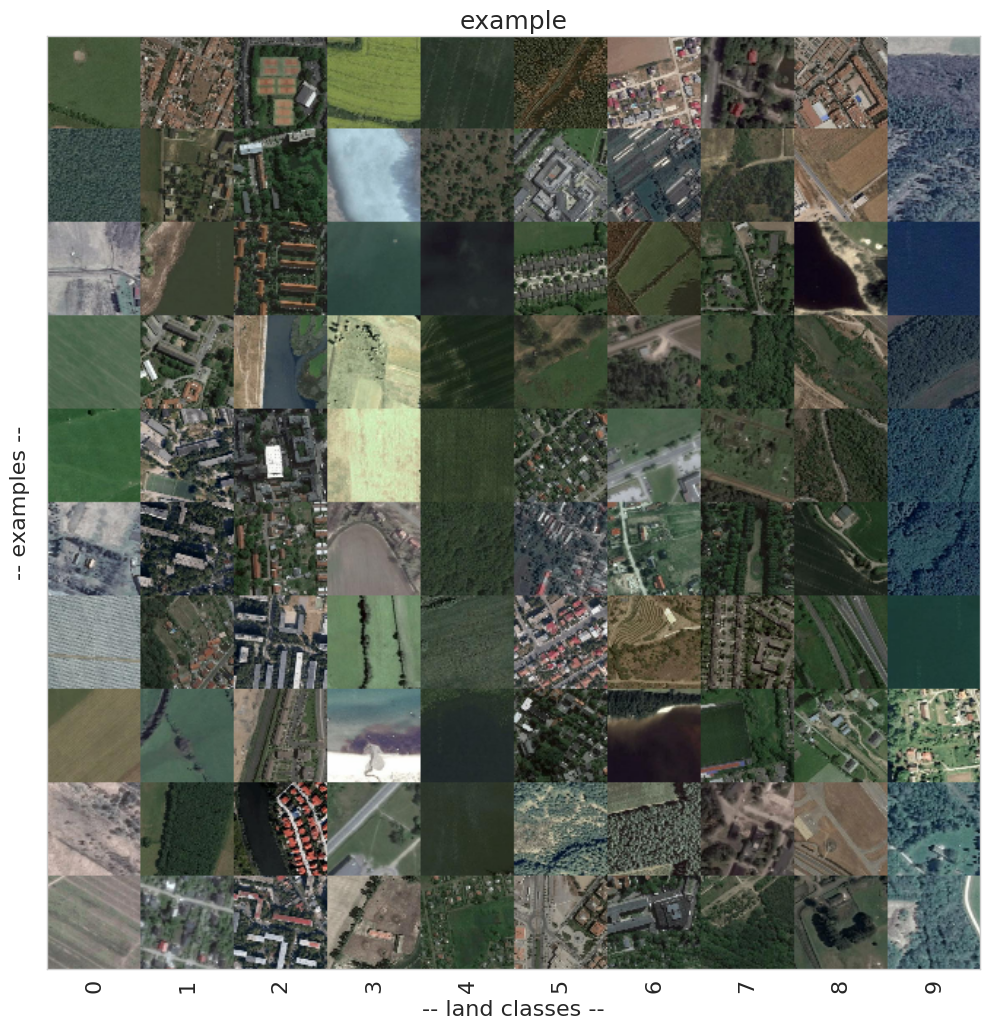

In [28]:
plot_examples(test_df['filename'].values, C)

In [29]:
import re
import abbreviate
abbr = abbreviate.Abbreviate()

def split_str(s, target_len=12):
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    words = s.split(" ")
    words = [abbr.abbreviate(w, target_len=target_len).capitalize() for w in words]
    if len(words)==1:
        return s #+ "\n"
    if len(words)>4:
        words = words[:3] + [words[-1]]
    else:
        words = words[:4]
    return " ".join(words[:(len(words)/2)]) + "\n" + " ".join(words[(len(words)/2):])


In [30]:
idx_to_class = {v:split_str(k) for k,v in dataset.class_to_idx.iteritems()}

df = pd.DataFrame(zip([idx_to_class[x] for x in labels], C), columns=["label", "cluster"])

df.head()

label  cluster
0  High Density\nUrban Fabric        0
1  High Density\nUrban Fabric        1
2  High Density\nUrban Fabric        5
3  High Density\nUrban Fabric        1
4  High Density\nUrban Fabric        1

In [31]:
xtab = df.groupby("cluster").apply(lambda x: x['label'].value_counts() / float(len(x)))
xtab = pd.DataFrame(xtab).reset_index().rename(columns={"level_1":"label", "label":"pct"})
xtab = xtab.pivot_table(values="pct", index="label", columns="cluster")
xtab

cluster                                     0         1         2         3  \
label                                                                         
Agrcltrl \nSeminatural Wetlands      0.500000  0.140543  0.154992  0.285016   
Airports                             0.024954  0.026051  0.021511  0.019544   
Forests                              0.091959  0.087785  0.060673  0.200326   
Green\nUrban Areas                   0.016174  0.054947  0.043574  0.052117   
High Density\nUrban Fabric           0.078558  0.278021  0.276338  0.073290   
Industrial Commercial\nPublic Units  0.112292  0.138573  0.234970  0.074919   
Low Density\nUrban Fabric            0.015712  0.066550  0.031440  0.029316   
Medium Density\nUrban Fabric         0.037431  0.140324  0.094319  0.042345   
Sports And\nLeisure Facilities       0.053604  0.048161  0.060673  0.074919   
Water\nBodies                        0.069316  0.019046  0.021511  0.148208   

cluster                                     4         5         6         7  \
label                                                                         
Agrcltrl \nSeminatural Wetlands      0.301800  0.091750  0.221892  0.342632   
Airports                             0.008162  0.004550  0.012493  0.010502   
Forests                              0.340938  0.053685  0.089233  0.190351   
Green\nUrban Areas                   0.071578  0.050349  0.052350  0.058746   
High Density\nUrban Fabric           0.015697  0.328632  0.207020  0.095832   
Industrial Commercial\nPublic Units  0.035370  0.148165  0.206425  0.106662   
Low Density\nUrban Fabric            0.027417  0.074007  0.044021  0.043321   
Medium Density\nUrban Fabric         0.038091  0.167273  0.085663  0.063669   
Sports And\nLeisure Facilities       0.039347  0.063998  0.046996  0.046275   
Water\nBodies                        0.121599  0.017592  0.033908  0.042009   

cluster                                     8         9  
label                                                    
Agrcltrl \nSeminatural Wetlands      0.212819  0.215525  
Airports                             0.009334  0.001826  
Forests                              0.087119  0.431963  
Green\nUrban Areas                   0.065961  0.023744  
High Density\nUrban Fabric           0.228998  0.061187  
Industrial Commercial\nPublic Units  0.200373  0.032877  
Low Density\nUrban Fabric            0.026758  0.032877  
Medium Density\nUrban Fabric         0.075296  0.062100  
Sports And\nLeisure Facilities       0.051027  0.018265  
Water\nBodies                        0.042315  0.119635

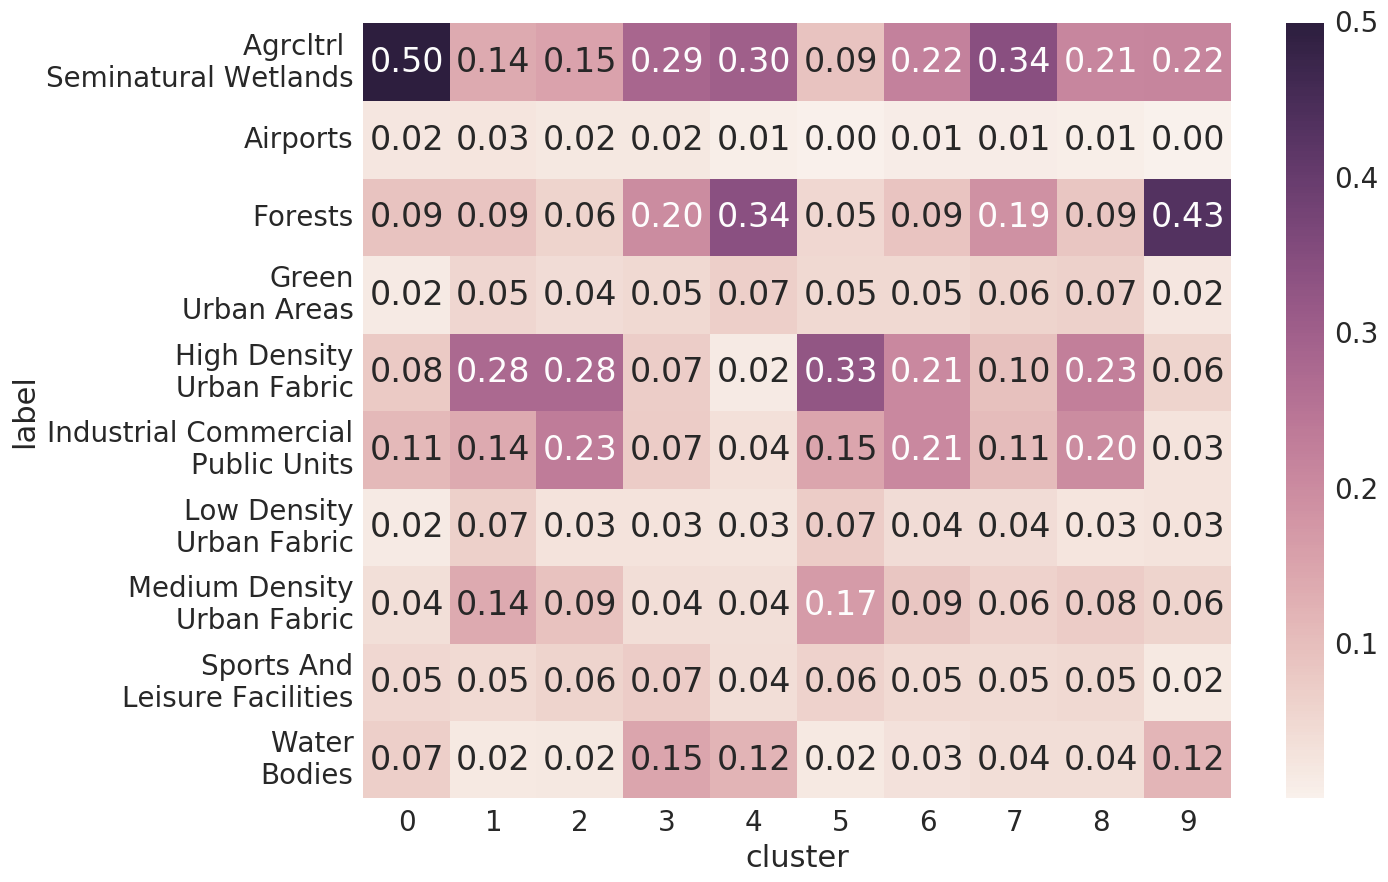

In [32]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
plt.figure(figsize = (14,10))
sns.heatmap(xtab, annot=True, fmt=".2f")


# Learn shallow classifier to predict land use class

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5)

In [89]:
X_train.shape, y_train.shape

((13980, 8192), (13980,))

In [90]:
from sklearn.ensemble import RandomForestClassifier

mod_rfc = RandomForestClassifier(n_estimators=30, n_jobs=48)

In [91]:
mod_rfc = mod_rfc.fit(X_train, y_train)
y_pred_test = mod_rfc.predict(X_test)
y_pred_train = mod_rfc.predict(X_train)


In [92]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, auc

print "train"
print "accuracy=%2.2f"%accuracy_score(y_train, y_pred_train)
print "precision=%2.2f"%precision_score(y_train, y_pred_train, average="macro")
print "recall=%2.2f"%recall_score(y_train, y_pred_train, average="macro")

print 
print "test"
print "accuracy=%2.2f"%accuracy_score(y_test, y_pred_test)
print "precision=%2.2f"%precision_score(y_test, y_pred_test, average="macro")
print "recall=%2.2f"%recall_score(y_test, y_pred_test, average="macro")

train
accuracy=1.00
precision=1.00
recall=1.00

test
accuracy=0.51
precision=0.38
recall=0.32
